In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from akita_utils.format_io import h5_to_df

In [3]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import average_stat_over_targets

In [4]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_single_mutagenesis"

In [5]:
keys_to_ignore = ["disruption_SCD",
                 "insertion_SCD"]

In [6]:
# reading and averaging data for model 0, bg 0
df_m0_bg09 = h5_to_df(data_dir+"/model_0_bg_09.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=keys_to_ignore) 

In [7]:
df_m0_bg09_tg = average_stat_over_targets(df_m0_bg09, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [8]:
df_m0_bg09_tg.columns

Index(['SCD_h1_m0_t0', 'SCD_h1_m0_t1', 'SCD_h1_m0_t2', 'SCD_h1_m0_t3',
       'SCD_h1_m0_t4', 'SCD_h1_m0_t5', 'background_index', 'chrom', 'end',
       'flank_bp', 'mutated_nucleotide', 'orientation', 'original_nucleotide',
       'position', 'spacer_bp', 'start', 'strand', 'disruption_SCD',
       'insertion_SCD', 'INS-16_h1_m0_t0', 'INS-16_h1_m0_t1',
       'INS-16_h1_m0_t2', 'INS-16_h1_m0_t3', 'INS-16_h1_m0_t4',
       'INS-16_h1_m0_t5', 'INS-64_h1_m0_t0', 'INS-64_h1_m0_t1',
       'INS-64_h1_m0_t2', 'INS-64_h1_m0_t3', 'INS-64_h1_m0_t4',
       'INS-64_h1_m0_t5', 'SCD_m0'],
      dtype='object')

In [9]:
# Initialize an empty list to store wild_type_average values for each site
wild_type_averages = []

In [10]:
non_wild_type_scd_values = np.zeros(49)

In [11]:
min = -40
max = 20

In [12]:
# getting the original colormap using cm.get_cmap() function 
orig_map=plt.cm.get_cmap('coolwarm') 
  
# reversing the original colormap using reversed() function 
reversed_map = orig_map.reversed() 

/tmp/SLURM_19864356/ipykernel_50305/2463017463.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('coolwarm')


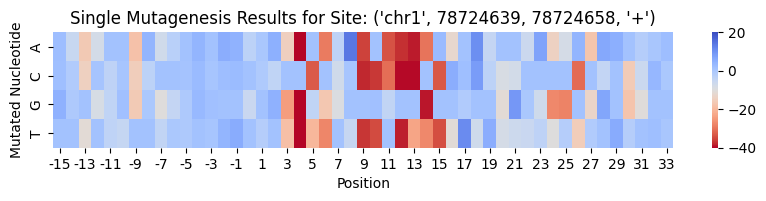

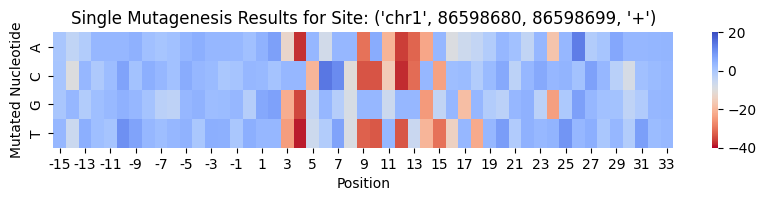

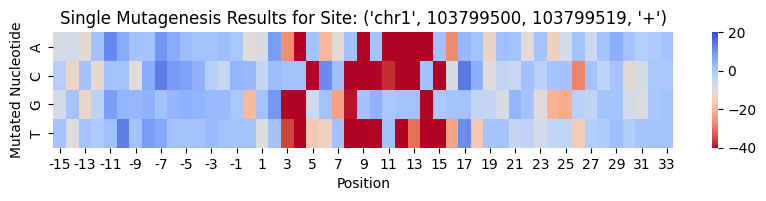

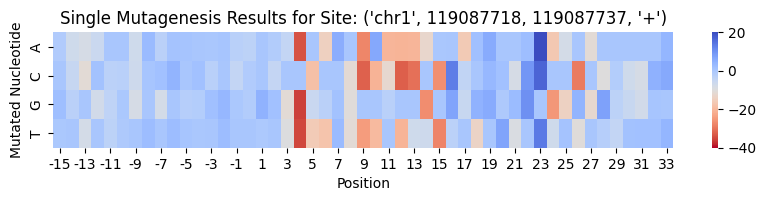

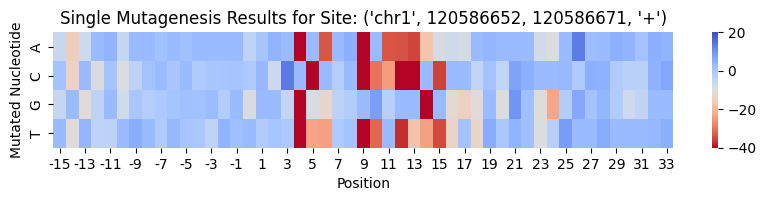

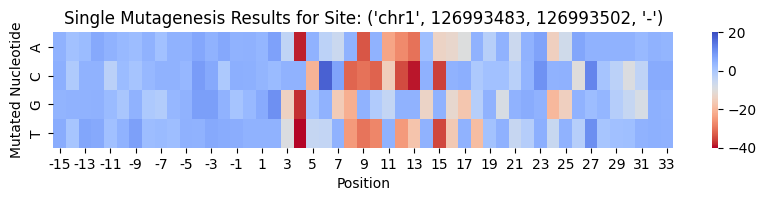

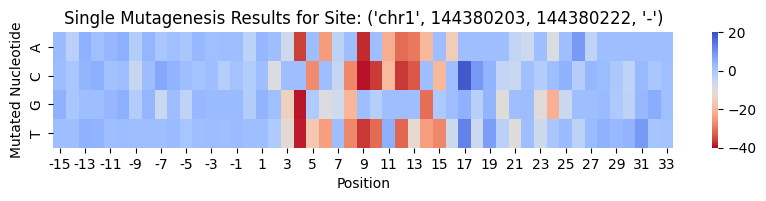

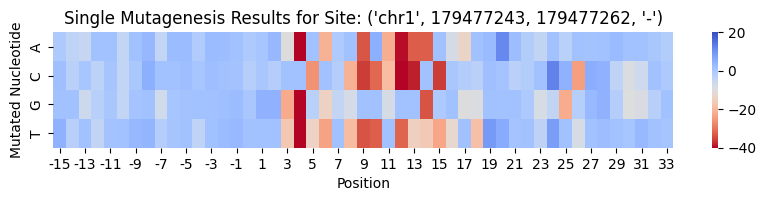

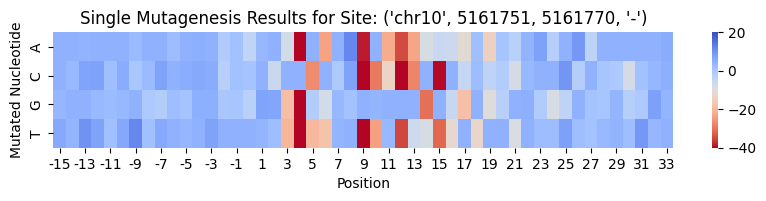

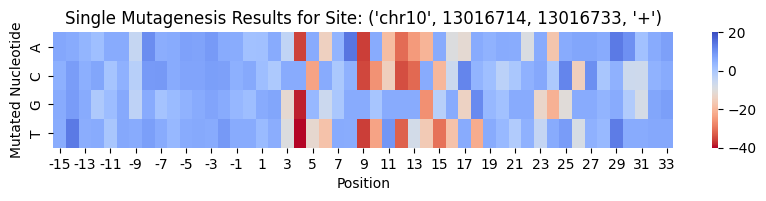

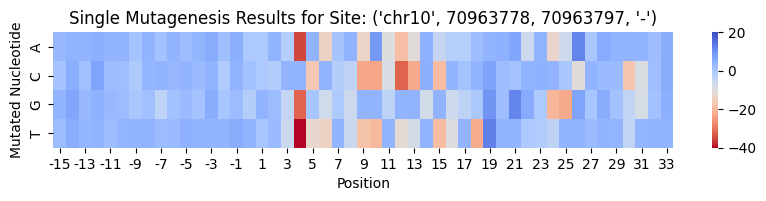

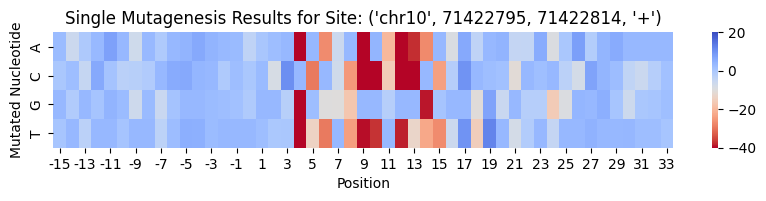

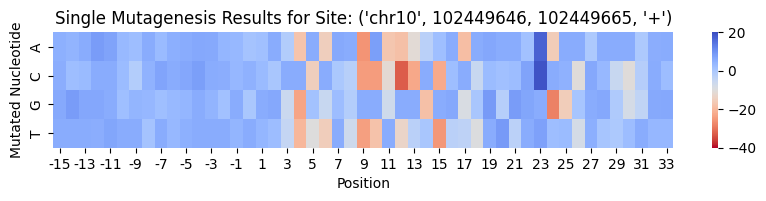

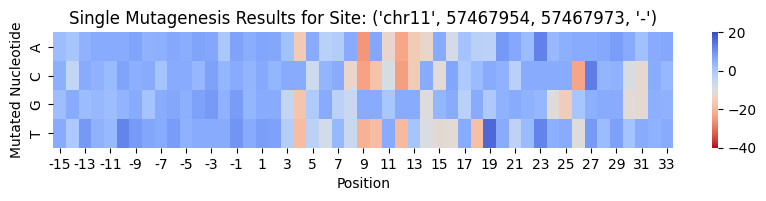

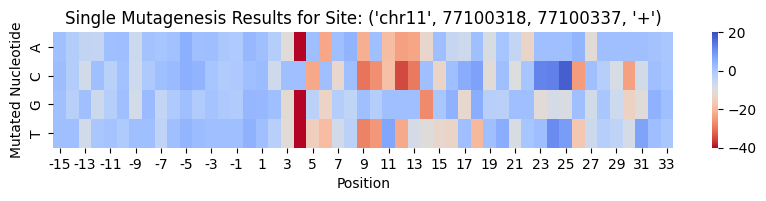

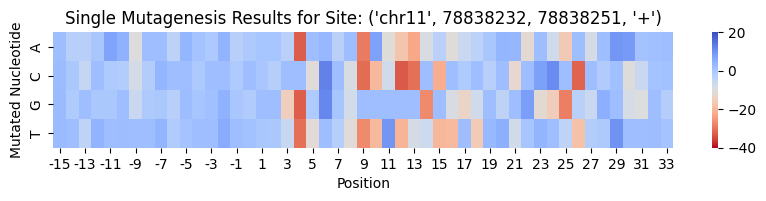

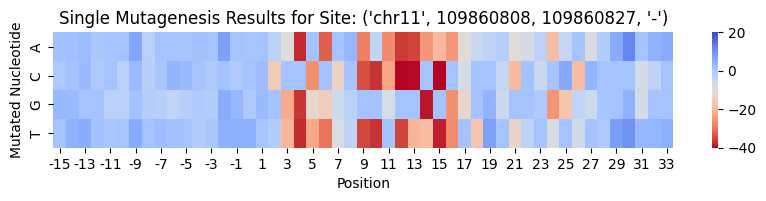

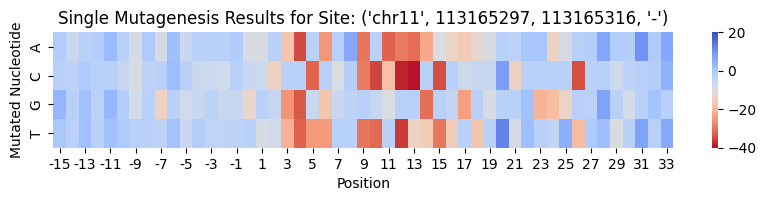

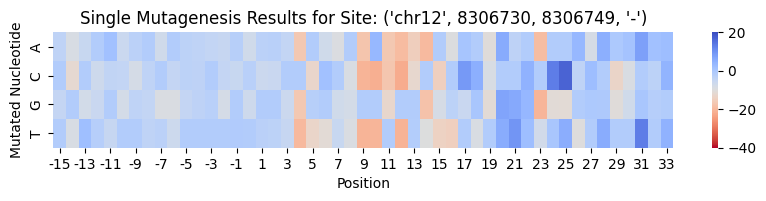

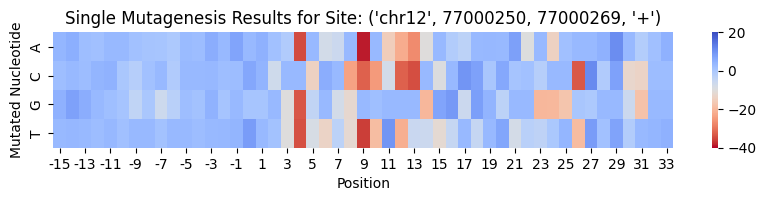

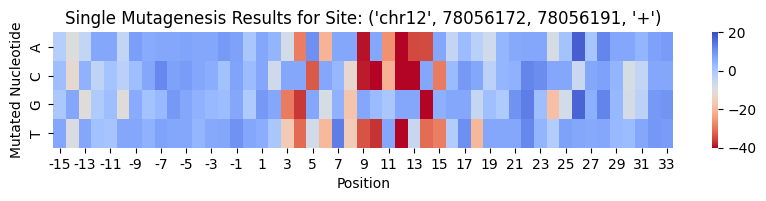

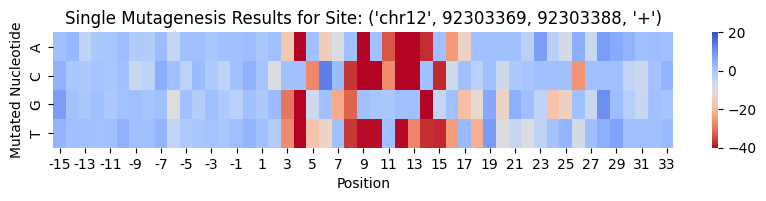

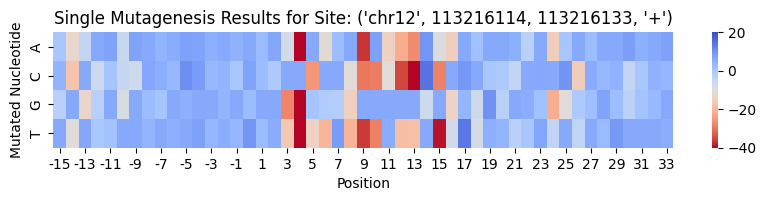

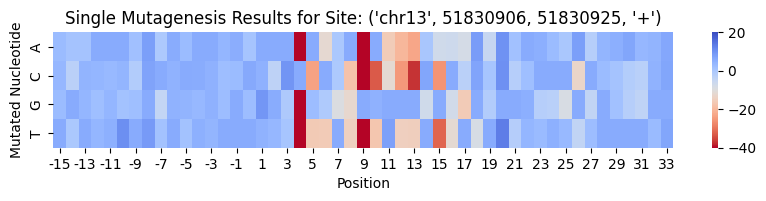

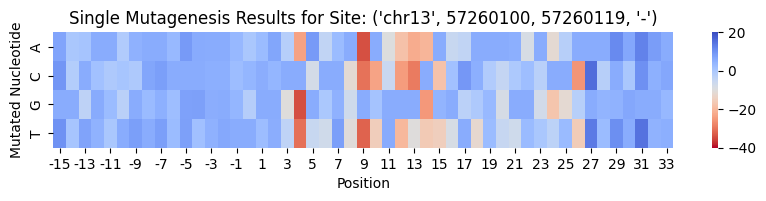

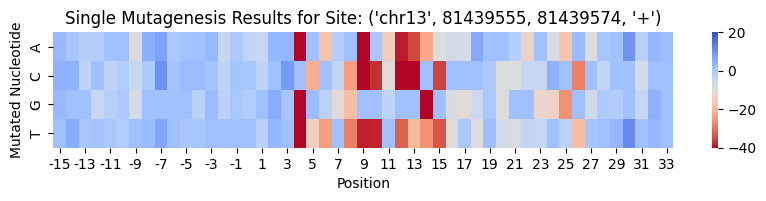

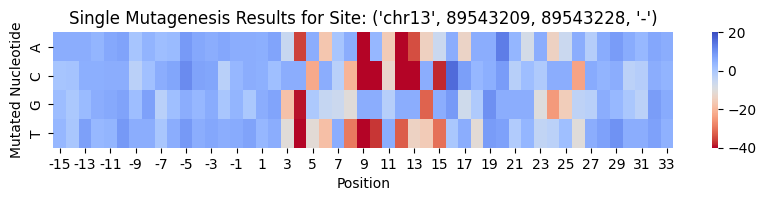

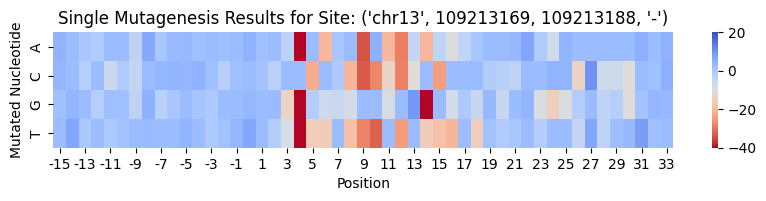

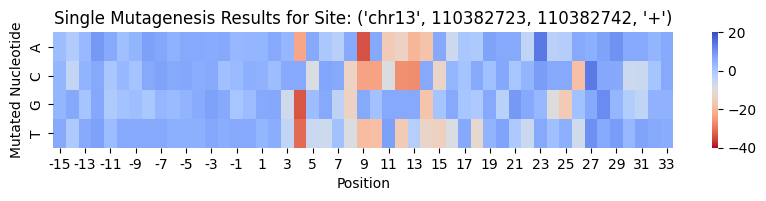

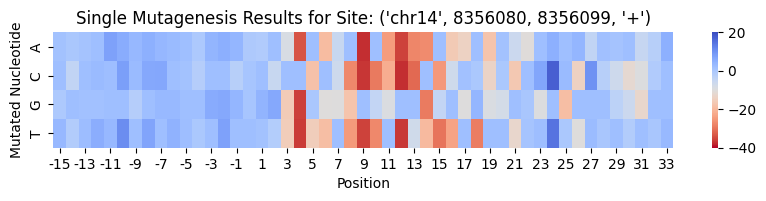

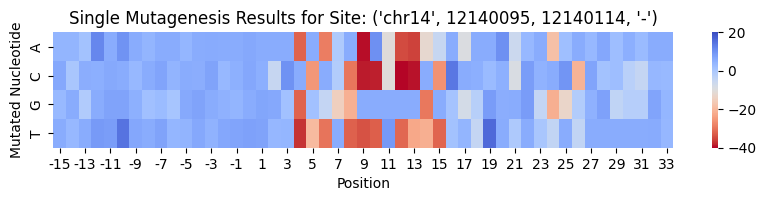

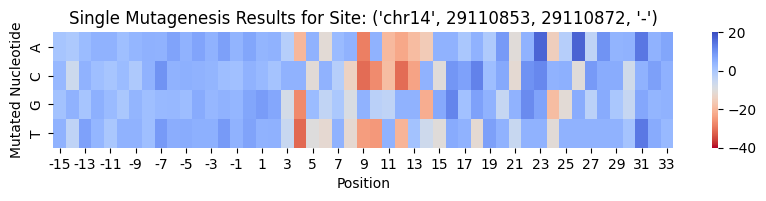

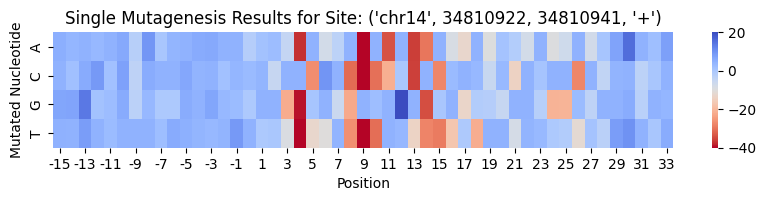

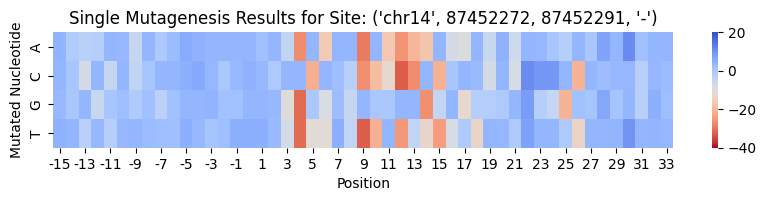

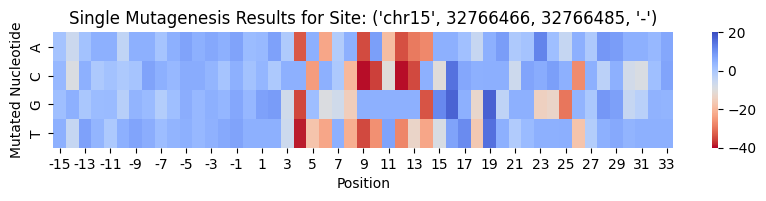

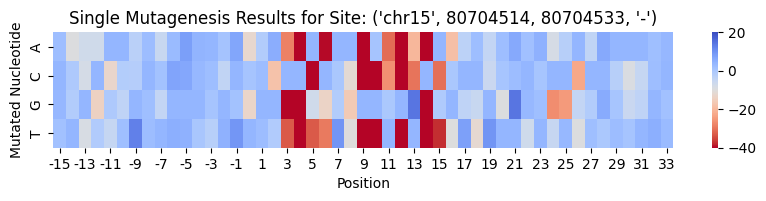

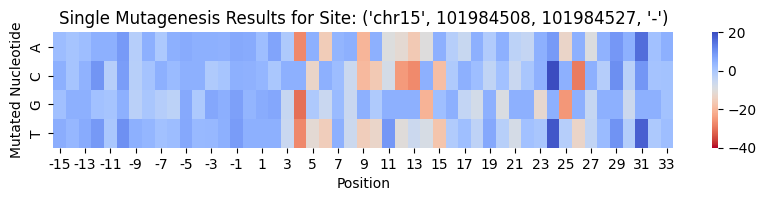

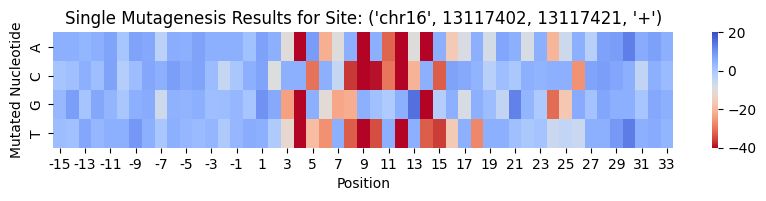

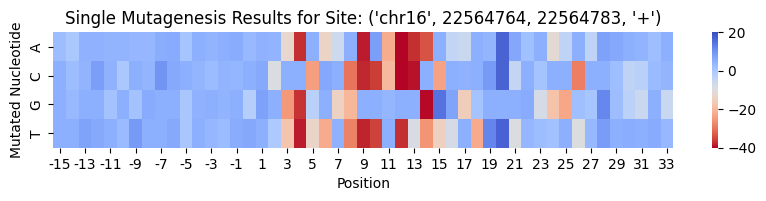

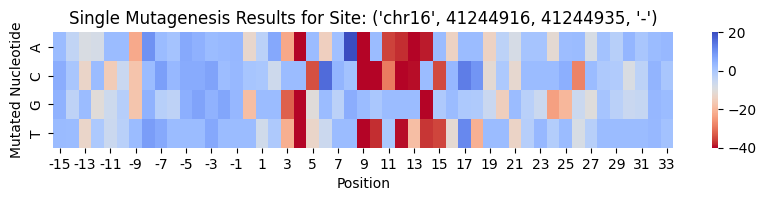

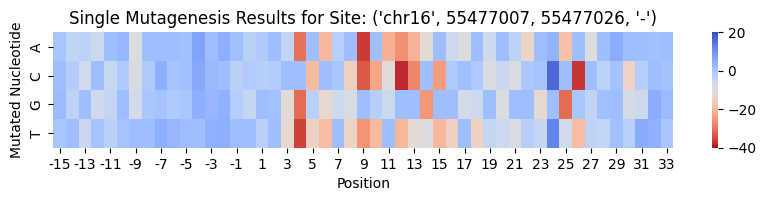

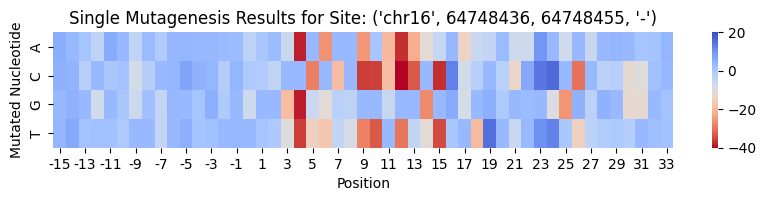

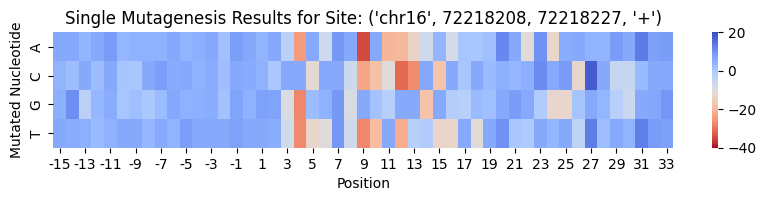

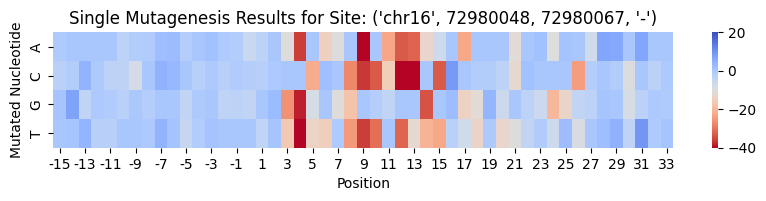

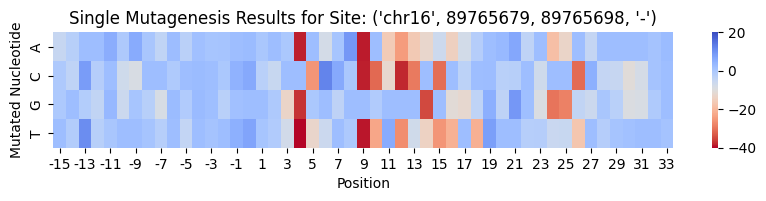

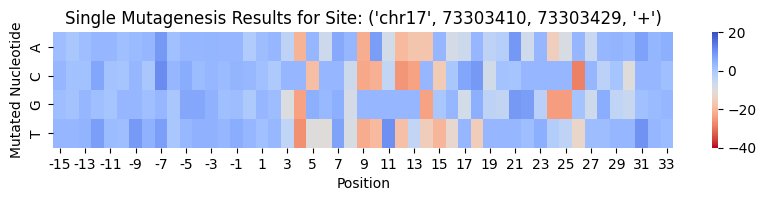

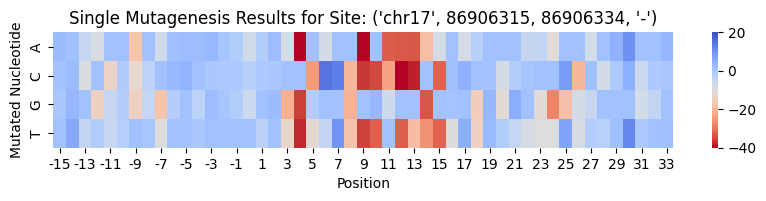

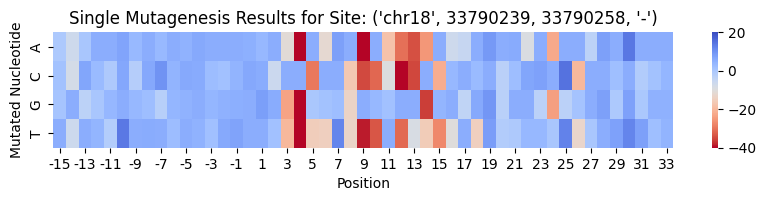

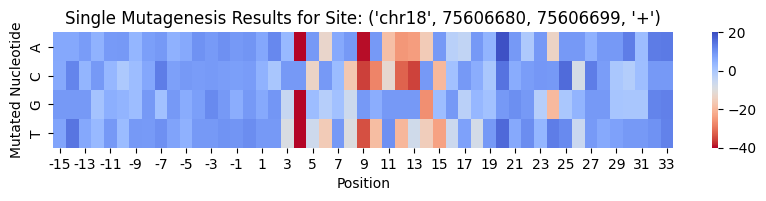

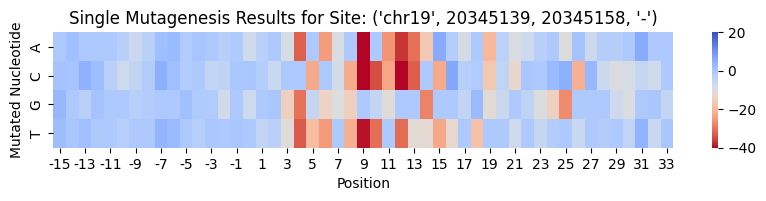

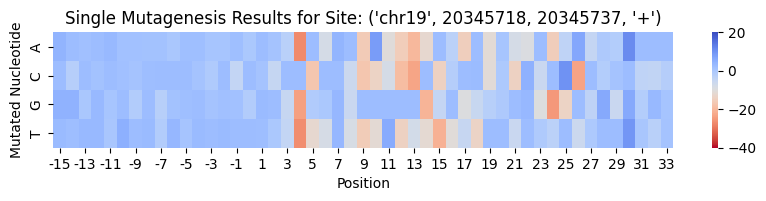

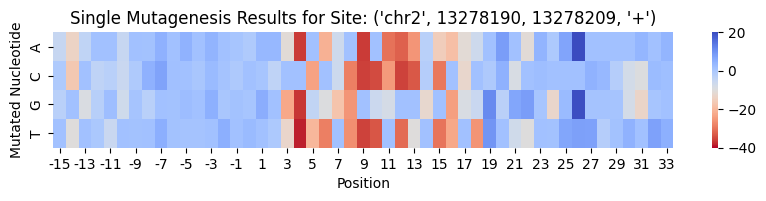

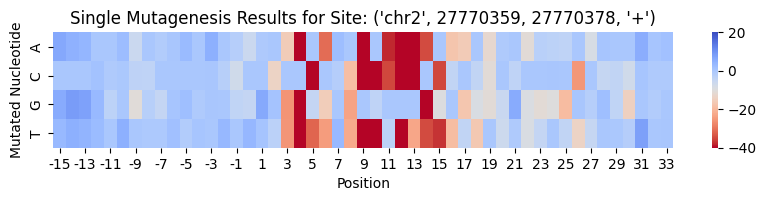

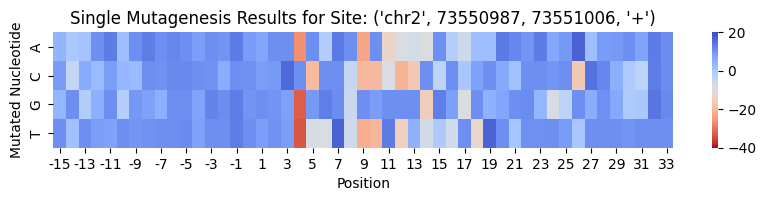

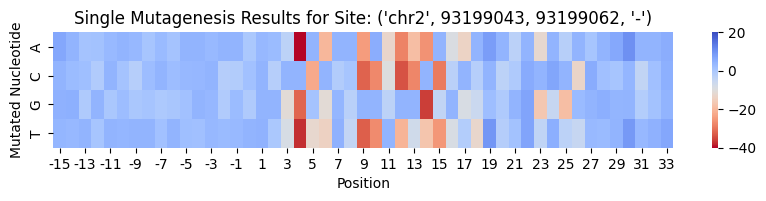

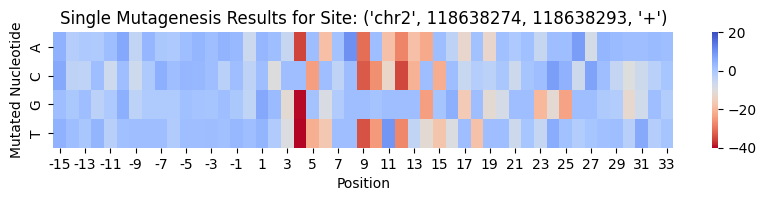

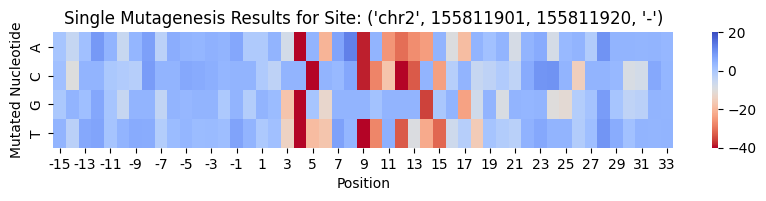

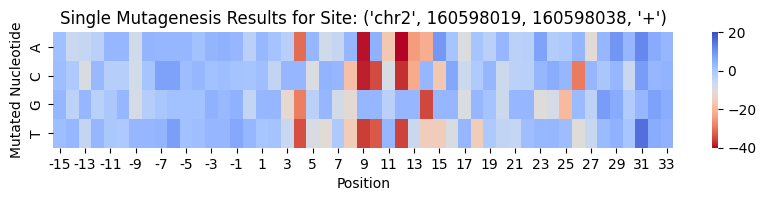

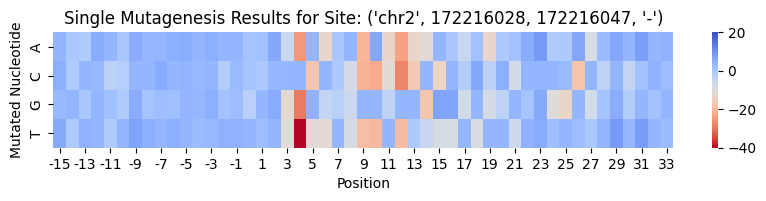

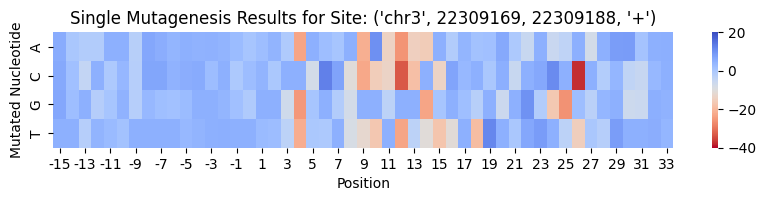

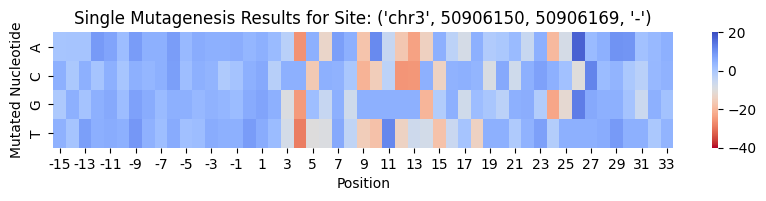

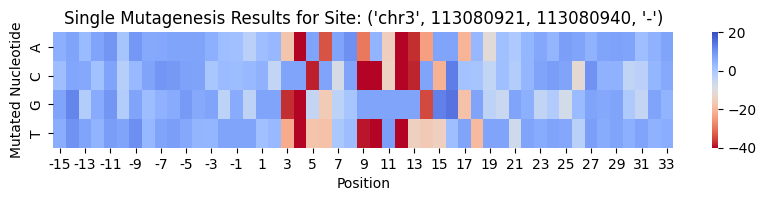

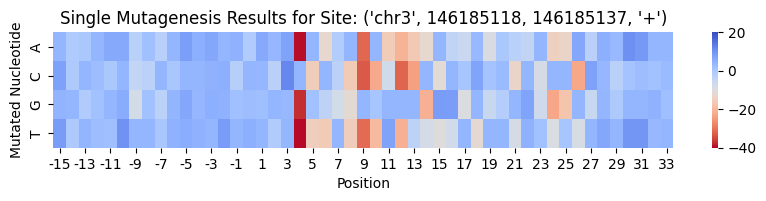

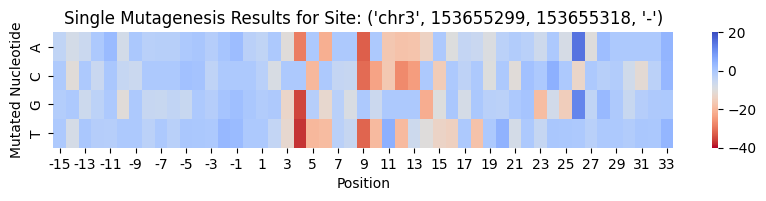

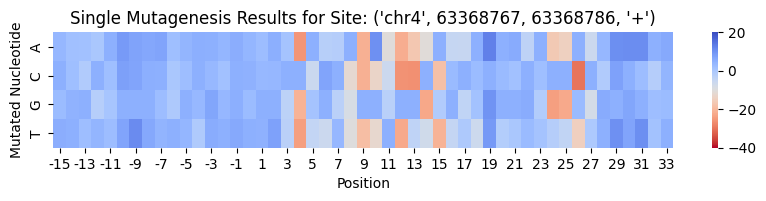

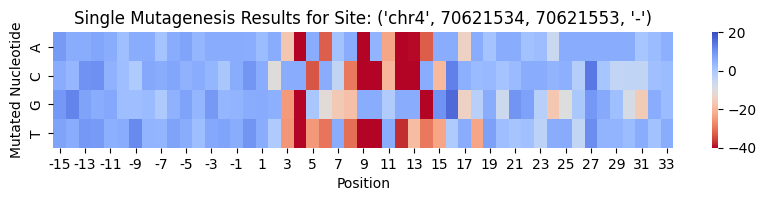

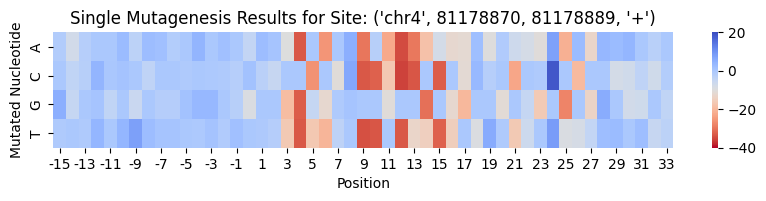

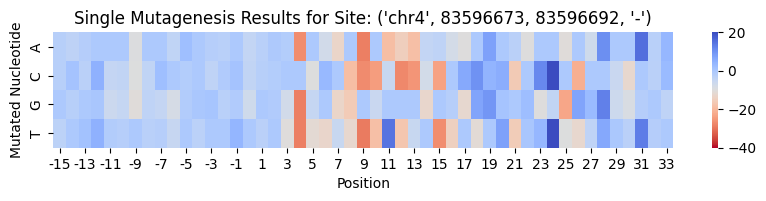

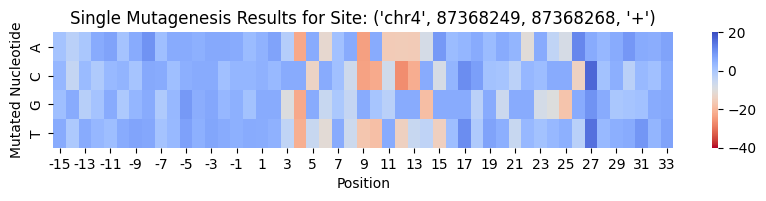

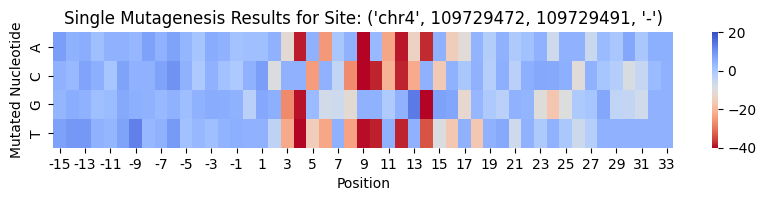

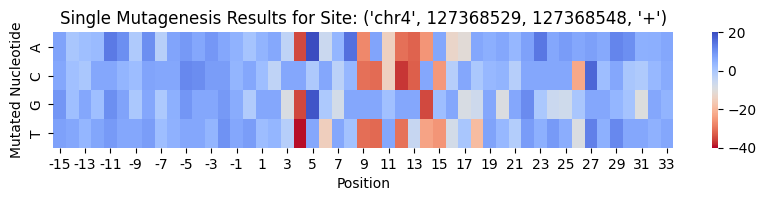

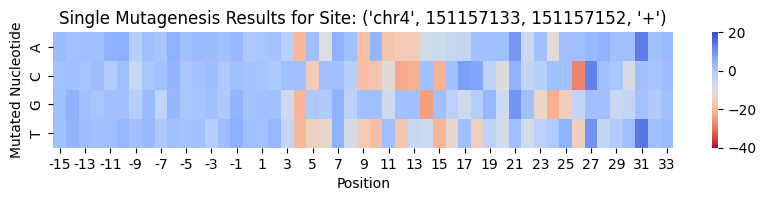

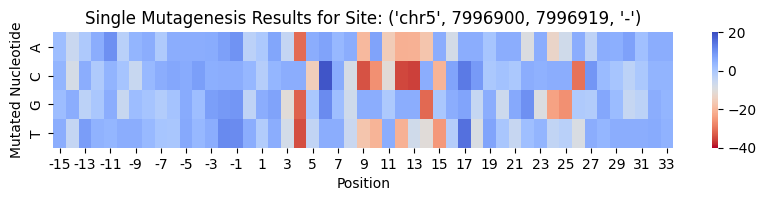

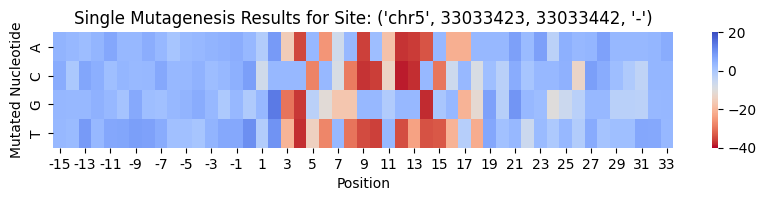

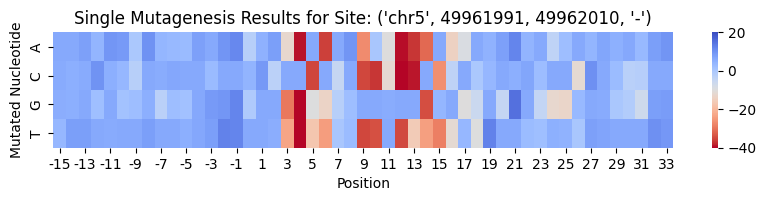

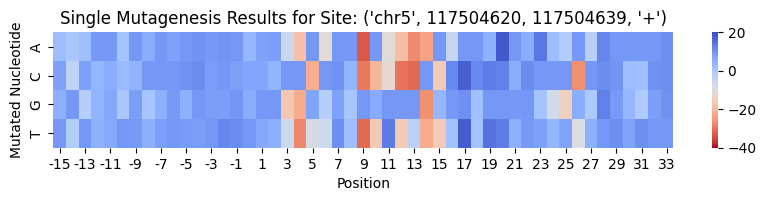

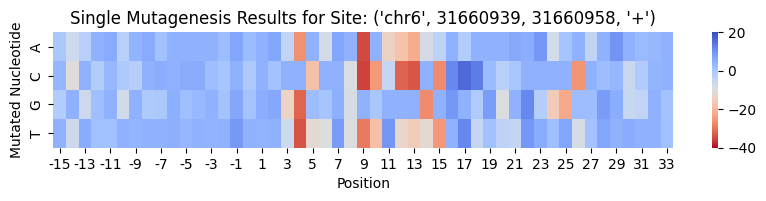

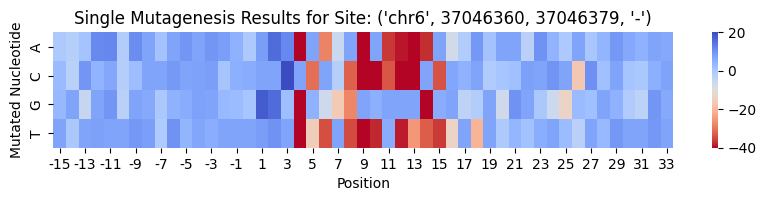

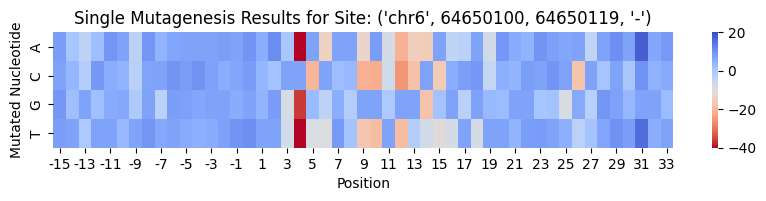

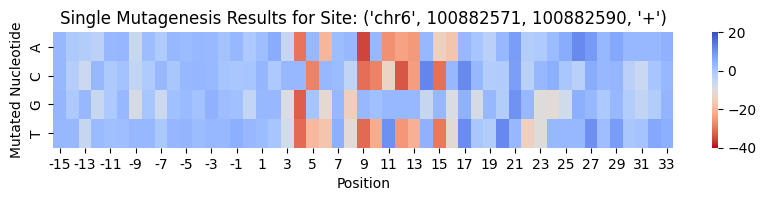

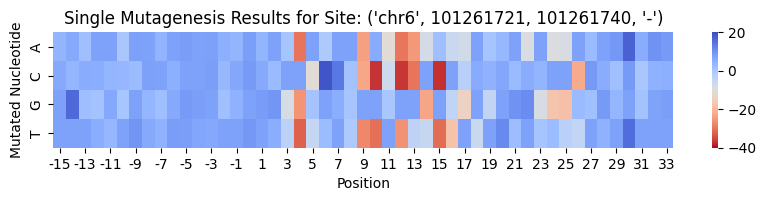

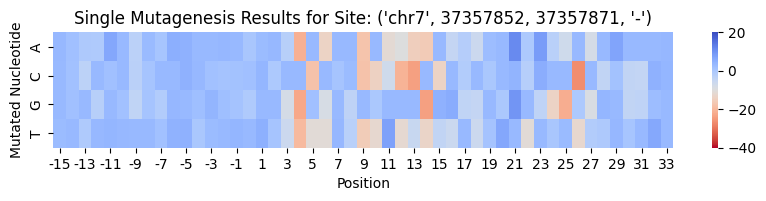

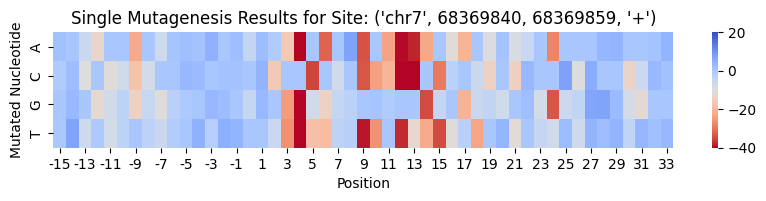

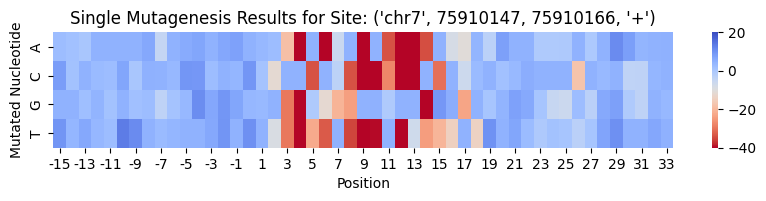

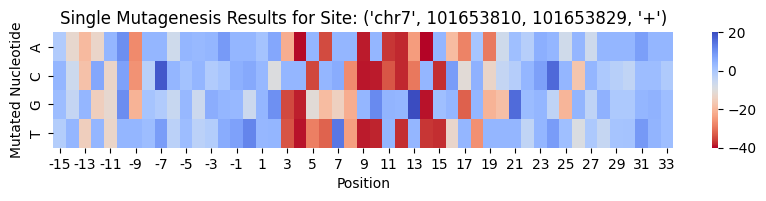

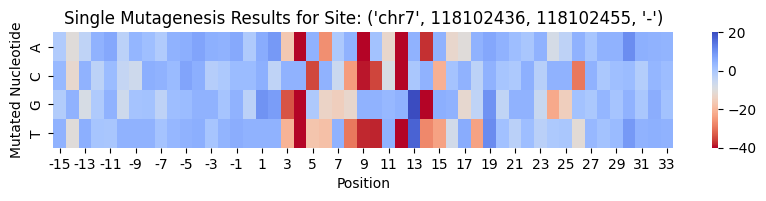

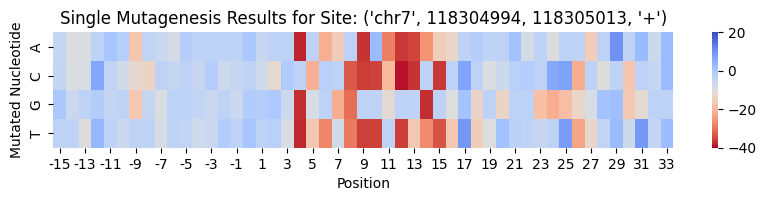

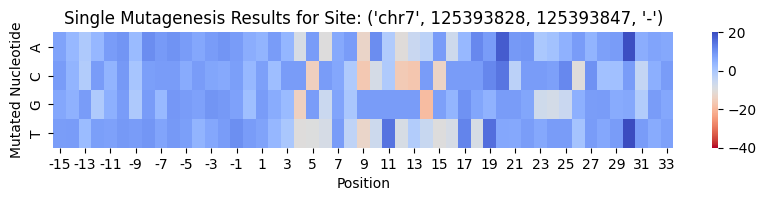

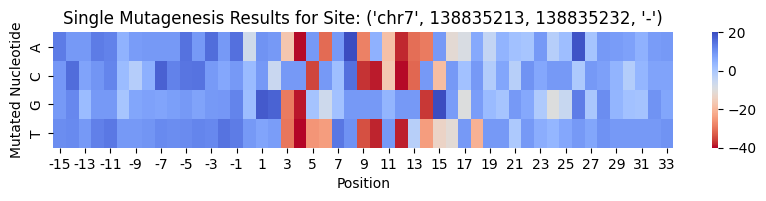

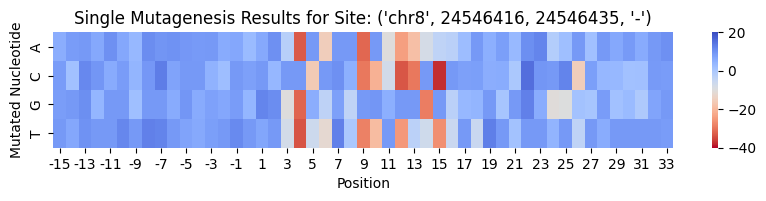

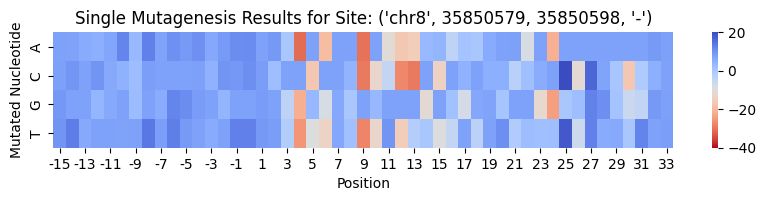

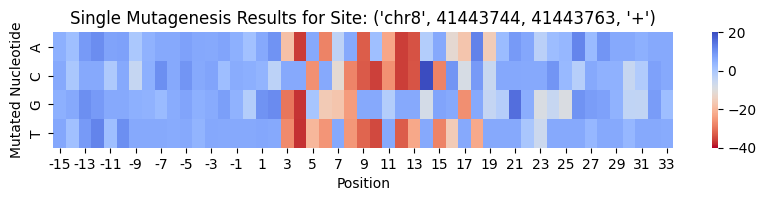

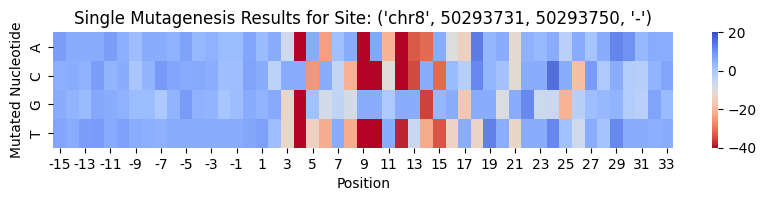

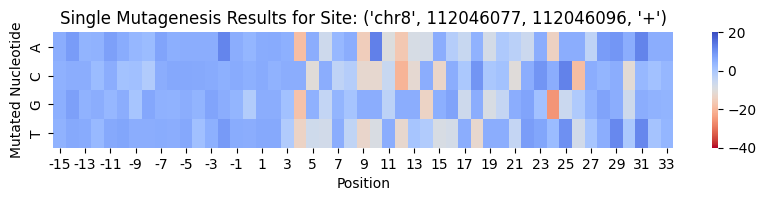

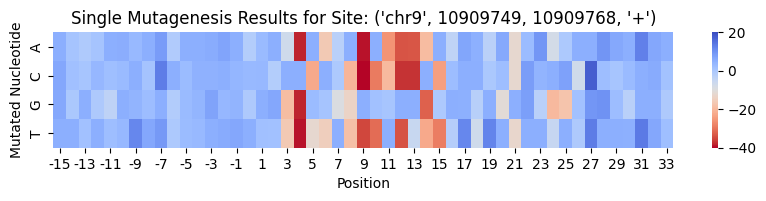

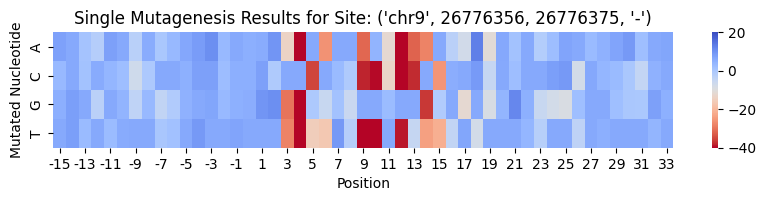

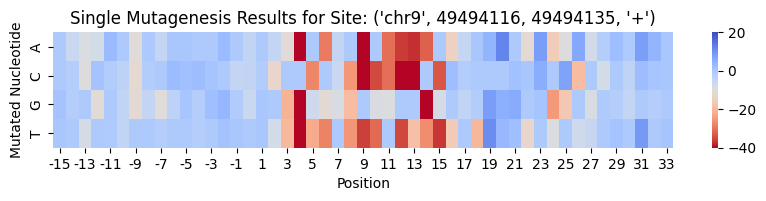

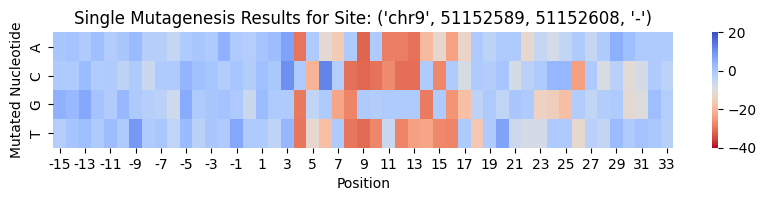

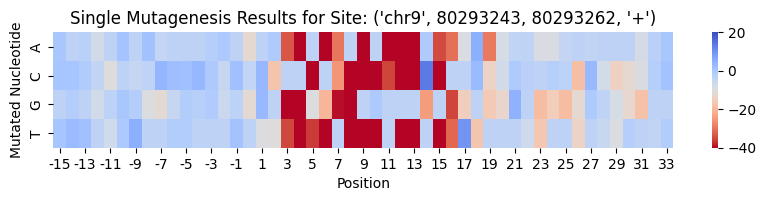

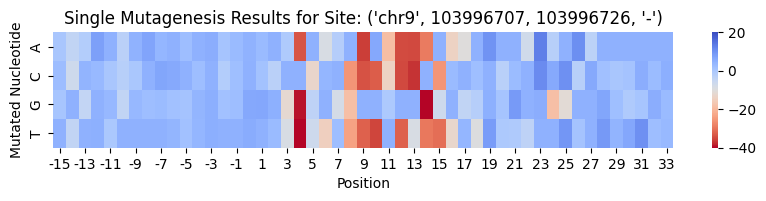

In [13]:
# Iterate over each site separately
for site, site_df in df_m0_bg09_tg.groupby(['chrom', 'start', 'end', 'strand']):
    # Initialize an empty DataFrame to store reshaped data
    reshaped_data = []

    # Calculate average SCD_m0 value for wild type (original_nucleotide)
    wild_type_average = site_df.loc[site_df['mutated_nucleotide'] == site_df['original_nucleotide'], 'SCD_m0'].mean()

    # Append wild_type_average value to the list
    wild_type_averages.append(wild_type_average)
    
    # Iterate over each position
    for position, position_df in site_df.groupby('position'):
        position_df['difference'] = position_df['SCD_m0'] - wild_type_average

        non_wild_type_scd_values[position + 15] += position_df[position_df['mutated_nucleotide'] != position_df['original_nucleotide']]['SCD_m0'].mean() - wild_type_average
        
        # Create a dictionary to store SCD_m0 values for each nucleotide
        position_data = {'position': position}
        for nucleotide, nucleotide_df in position_df.groupby('mutated_nucleotide'):
            position_data[nucleotide] = nucleotide_df['difference'].iloc[0]  # Take the first value assuming only one entry per position and nucleotide
        reshaped_data.append(position_data)
    
    # Convert the list of dictionaries to a DataFrame
    reshaped_df = pd.DataFrame(reshaped_data)

    # Plot heatmap
    plt.figure(figsize=(10, 1.5))
    sns.heatmap(reshaped_df.set_index('position').T, cmap=reversed_map, annot=False, vmin=min, vmax=max)
    plt.title(f'Single Mutagenesis Results for Site: {site}')
    plt.xlabel('Position')
    plt.ylabel('Mutated Nucleotide')
    plt.show()

# Calculate the average SCD_m0 values for non-wild-type substitutions across all sites
mean_non_wild_type_scd = non_wild_type_scd_values / len(df_m0_bg09_tg.groupby(['chrom', 'start', 'end', 'strand']))

## Averaged over all 100 sites

In [17]:
all_wild_type_average = np.array(wild_type_averages).mean()

In [32]:
# max and min unified with pairwise mutagenesis
unified_min = -50
unified_max = 3

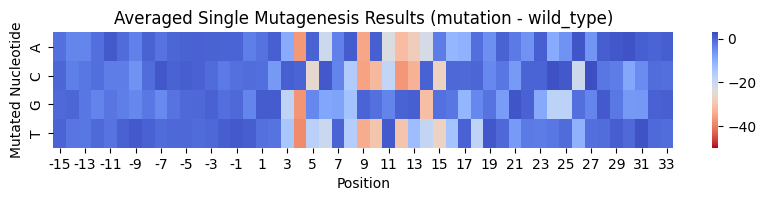

In [33]:
# Calculate the mean SCD_m0 value for each position and each nucleotide across all sites
mean_scd_m0 = df_m0_bg09_tg.groupby(['position', 'mutated_nucleotide'])['SCD_m0'].mean().unstack().T - all_wild_type_average

# Plot heatmap of averaged SCD_m0 values
plt.figure(figsize=(10, 1.5))
sns.heatmap(mean_scd_m0, cmap=reversed_map, annot=False, vmin=unified_min, vmax=unified_max)
plt.title('Averaged Single Mutagenesis Results (mutation - wild_type)')
plt.ylabel('Mutated Nucleotide')
plt.xlabel('Position')
plt.show()

In [19]:
# averaged wt SCD for each site
# wild_type_averages 

In [20]:
# average difference between non-wt substitutions and wt for each position (average over all non-wt nucleotides and all sites)
# non_wild_type_scd_values

In [21]:
np.savez("single_mutation_SCD", wild_type_averages=wild_type_averages, mean_non_wild_type_scd=mean_non_wild_type_scd)